In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

# Cross-Validation

We follow Rosser et al. and use a maximum-likelihood approach to finding the "best" parameters for the time and space bandwidths.

- Use a "training" dataset of 180 days
- For each of the next 60 days we compute the "risk" using from the start of the 180 days to before the current day.
- Then for the current day, we compute the log likelihood using the actual events which occurred.
- Following Rosser et al. if an event occurs at a location which had 0 risk, we convert this to (log value) -27.6

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import shelve

import open_cp.network
import open_cp.geometry
import open_cp.network_hotspot
import open_cp.logger
open_cp.logger.log_to_true_stdout()

In [3]:
import pickle, lzma
with lzma.open("input_old.pic.xz", "rb") as f:
    timed_points = pickle.load(f)
with open("input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [4]:
trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

In [5]:
def log_likelihood(result, network_timed_points):
    logli = 0
    for s, e in zip(network_timed_points.start_keys, network_timed_points.end_keys):
        edge_index, _ = result.graph.find_edge(s,e)
        if result.risks[edge_index] == 0:
            logli -= 27.6
        else:
            logli += np.log(result.risks[edge_index])
    return logli

In [6]:
timed_points.time_range

(numpy.datetime64('2001-01-01T11:30:00.000'),
 numpy.datetime64('2014-05-24T18:00:00.000'))

In [7]:
tstart = np.datetime64("2013-01-01")
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")

def score(predictor):
    out = 0
    risks = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        result = predictor.predict(cutoff_time=tstart, predict_time=start)
        ntp = predictor.network_timed_points
        mask = (ntp.timestamps > start) & (ntp.timestamps <= end)
        ntp = ntp[mask]
        out += log_likelihood(result, ntp)
        risks[start] = result.risks
    return out, risks

# With the "fast" exact caching predictor

Uses a lot of memory...

In [13]:
predictor = open_cp.network_hotspot.FastPredictor(predictor, 2000)

In [14]:
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))

In [ ]:
results = dict()

for sl in space_lengths:
    predictor.kernel = open_cp.network_hotspot.TriangleKernel(sl)
    for tl in time_lengths:
        predictor.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(tl)
        results[ (sl, tl) ], _ = score(predictor)

In [ ]:
with open("cross_validate.pic", "wb") as f:
    pickle.dump(results, f)

# With the approximate predictor

This takes a couple of days to run...  (single threaded; but without shared memory, this would be hard to multi-process.  Damn Python...)

Thought about serialising the actual risks, but a quick estimate shows that this will be around 30 GB in size!

In [ ]:
pred = open_cp.network_hotspot.ApproxPredictorCaching(predictor)
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))

In [ ]:
results = dict()

for sl in space_lengths:
    pred.kernel = open_cp.network_hotspot.TriangleKernel(sl)
    for tl in time_lengths:
        pred.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(tl)
        key = (sl, tl)
        results[key], _ = score(pred)

In [ ]:
with open("cross_validate_approx.pic", "wb") as f:
    pickle.dump(results, f)

## Try to visualise

We see something a bit different to the paper of Rosser et al.

- Plot only values above the 25% percentile
- We find a "blob" shape, which seems to different to the paper
- E.g. 2000m and 100 days seems no better than a very small time/space window, whereas Rosser et al find seemingly no drop-off.
- We find the maximum likelihood at 500m and 55days, a tighter bandwidth than Rosser et al.

In [8]:
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))
with open("cross_validate_approx.pic", "rb") as f:
    results = pickle.load(f)

In [9]:
len(space_lengths), len(time_lengths)

(39, 19)

In [10]:
data = np.empty((39,19))
for i, sl in enumerate(space_lengths):
    for j, tl in enumerate(time_lengths):
        data[i,j] = results[(sl,tl)]

ordered = data.copy().ravel()
ordered.sort()
cutoff = ordered[int(len(ordered) * 0.25)]
data = np.ma.masked_where(data<cutoff, data)

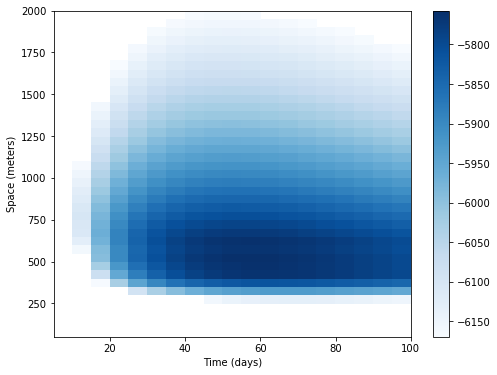

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.pcolor(range(5,105,5), range(50,2050,50), data, cmap="Blues")
ax.set(xlabel="Time (days)", ylabel="Space (meters)")
fig.colorbar(mappable, ax=ax)
None

In [12]:
print(max(results.values()))
[k for k, v in results.items() if v > -5758]

-5757.27829528


[(500, 55)]